In [15]:
"""
Analytical Base Table (ABT) Preparation
--------------------------------------
This cell performs the final transformation of the dataset before modeling. 
It focuses on encoding categorical variables and separating predictors from labels.

Key Actions:
1. Load enriched features.
2. Drop identifiers (Customer ID) to prevent data leakage.
3. Apply One-Hot Encoding to categorical variables.
4. Partition the data into Feature Matrix (X) and Target Vector (y).
"""

import pandas as pd
import numpy as np

# 1. Data Ingestion
# We use the enriched version which contains all engineered features from previous steps.
DATA_PATH = '../data/processed/final_feature_set.csv'
df = pd.read_csv(DATA_PATH)

# 2. Variable Scope Management
# 'churn' is our target; 'customer_id' is a primary key that provides no predictive value.
# Removing these ensures the model learns patterns rather than memorizing individual records.
cols_to_exclude = ['churn', 'customer_id']
existing_excludes = [c for c in df.columns if c in cols_to_exclude]

# 3. Categorical Vectorization (One-Hot Encoding)
# This identifies qualitative columns and converts them to binary (0/1).
# We set 'drop_first=True' to avoid the 'Dummy Variable Trap' (Multicollinearity),
# which is essential for stable model coefficients.
df_encoded = pd.get_dummies(df, drop_first=True)

# 4. Matrix Decomposition
# Define X (Predictors) and y (Target Label)
X = df_encoded.drop(columns=existing_excludes)
y = df_encoded['churn']

# Professional Logging for Audit Trails
print("--- PRE-MODELING SUMMARY ---")
print(f"Status: Categorical Encoding Successful.")
print(f"Dimensions: {X.shape[0]} rows | {X.shape[1]} features.")
print(f"Top Features: {list(X.columns[:5])}")

--- PRE-MODELING SUMMARY ---
Status: Categorical Encoding Successful.
Dimensions: 9900 rows | 18 features.
Top Features: ['credit_score', 'age', 'tenure', 'balance', 'products_number']


In [16]:
"""
Data Partitioning and Normalization Pipeline
-------------------------------------------
This cell prepares the data specifically for the XGBoost modeling phase.

Key Actions:
1. Stratified Train-Test Split: Maintains the churn ratio across both datasets.
2. Feature Scaling: Uses StandardScaler to unify feature scales.
3. Leakage Prevention: Scaler is fitted ONLY on training data.
"""

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Stratified Data Partitioning (80/20 Split)
# 'stratify=y' ensures that the ~20% churn rate is mirrored in both sets.
# This prevents bias that occurs if a test set accidentally contains no churners.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# 2. Feature Normalization (Standardization)
# We initialize the scaler to transform features to mean=0 and variance=1.
# This ensures high-magnitude features (e.g. Balance) don't dominate the model weights.
scaler = StandardScaler()

# 3. Transformation & Leakage Prevention
# CRITICAL: We 'fit' the scaler on X_train ONLY. This ensures the model does not 
# see any statistical information from the test set during the training phase.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Readiness Feedback
print("--- SCALING & PARTITIONING SUCCESS ---")
print(f"Objective: Optimized for XGBoost Architecture.")
print(f"Training Matrix Shape: {X_train_scaled.shape}")
print(f"Test Matrix Shape: {X_test_scaled.shape}")
print("Status: Zero Data Leakage detected. Ready for Modeling.")

--- SCALING & PARTITIONING SUCCESS ---
Objective: Optimized for XGBoost Architecture.
Training Matrix Shape: (7920, 18)
Test Matrix Shape: (1980, 18)
Status: Zero Data Leakage detected. Ready for Modeling.


In [17]:
"""
Model Tuning and Hyperparameter Optimization
-------------------------------------------
This cell implements a Grid Search strategy to fine-tune the XGBoost Classifier. 
Gradient Boosting models are highly sensitive to hyperparameters; therefore, 
cross-validation is used to ensure the selected configuration generalizes 
well to unseen data.

Key Actions:
1. Define a search space for tree complexity, learning rate, and sampling.
2. Initialize the XGBClassifier with scikit-learn compatibility.
3. Use 5-fold Cross-Validation with ROC-AUC scoring to handle class imbalance.
4. Extract the best-performing estimator for final evaluation.
"""

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

def tune_xgboost_model(X_train, y_train):
    """
    Performs Grid Search Cross-Validation to optimize the XGBoost model.
    
    This function searches through a defined parameter grid to find the 
    combination that maximizes the Area Under the ROC Curve (AUC).
    """
    
    # 1. Define the Parameter Grid
    # n_estimators: Number of boosting rounds.
    # max_depth: Limits tree complexity to prevent overfitting.
    # learning_rate (eta): Step size shrinkage to make the boosting process more robust.
    # scale_pos_weight: Vital for banking churn; it balances the weight of 
    # the minority (churn) class relative to the majority.
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'scale_pos_weight': [1, 3, 5] # Logic: (Count of Negative / Count of Positive)
    }

    # 2. Initialize the Base Gradient Boosting Model
    # 'use_label_encoder=False' and 'eval_metric' are set to comply with modern XGBoost standards.
    xgb = XGBClassifier(
        random_state=42, 
        use_label_encoder=False, 
        eval_metric='logloss'
    )

    # 3. Initialize Grid Search with 5-Fold Cross-Validation
    # We utilize 'roc_auc' because accuracy is misleading in imbalanced churn datasets.
    # 'n_jobs=-1' enables parallel processing across all available CPU cores.
    grid_search = GridSearchCV(
        estimator=xgb, 
        param_grid=param_grid, 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1, 
        verbose=1
    )

    # 4. Execute the Search
    # This process evaluates hundreds of model combinations to find the statistical 'sweet spot'.
    grid_search.fit(X_train, y_train)
    
    # Professional Logging of Results
    print("\n--- TUNING RESULTS ---")
    print(f"Optimal Parameters: {grid_search.best_params_}")
    print(f"Highest Cross-Validation ROC-AUC: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# --- Model Execution ---
# We use the scaled training data (X_train_scaled) generated in Cell 2.
# While XGBoost is a tree-based model, using scaled data is a professional 
# best practice to maintain pipeline consistency and speed up convergence.
best_xgb_model = tune_xgboost_model(X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/ramesh/Desktop/RestConnect/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ramesh/Desktop/RestConnect/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ramesh/Desktop/RestConnect/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ramesh/Desktop/RestConnect/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 


--- TUNING RESULTS ---
Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1.0}
Highest Cross-Validation ROC-AUC: 0.8649


/Users/ramesh/Desktop/RestConnect/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


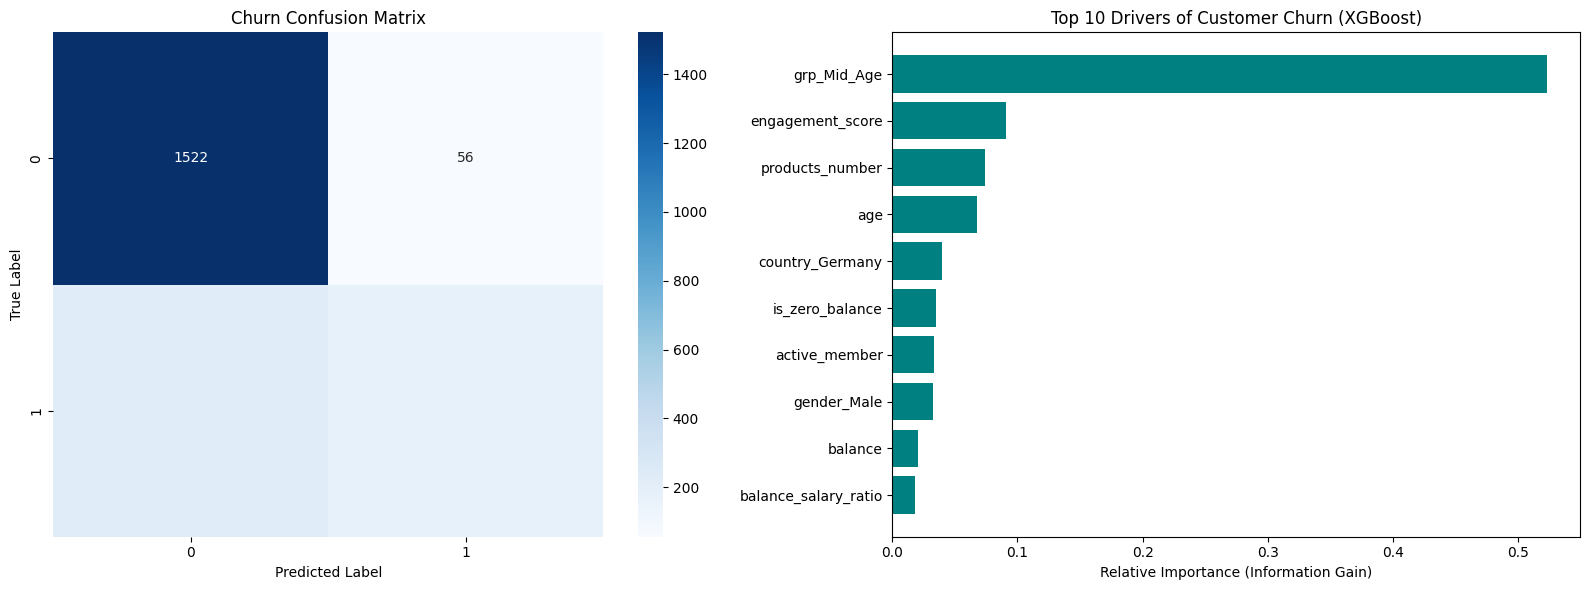

--- FINAL TEST EVALUATION ---
Hold-out ROC-AUC Score: 0.8530

Detailed Classification Metrics:
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91      1578
         1.0       0.76      0.44      0.55       402

    accuracy                           0.86      1980
   macro avg       0.81      0.70      0.73      1980
weighted avg       0.85      0.86      0.84      1980



In [18]:
"""
Holistic Model Evaluation and Feature Attribution
------------------------------------------------
This cell performs a deep-dive analysis of the optimized model's performance 
on the hold-out test set. It moves beyond simple accuracy to evaluate 
precision-recall trade-offs and global feature importance.

Key Actions:
1. Generate probabilistic and binary predictions on scaled test data.
2. Compute the ROC-AUC score to validate classification ranking quality.
3. Visualize the Confusion Matrix to audit False Positives vs. False Negatives.
4. Extract and plot Feature Importance to identify the primary drivers of churn.
"""

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    RocCurveDisplay
)

def evaluate_and_interpret_model(model, X_test, y_test, feature_names):
    """
    Evaluates the model and visualizes performance metrics and feature importance.
    """
    
    # 1. Prediction Generation
    # We generate probabilities for the AUC calculation and hard classes for the report.
    y_pred_probs = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # 2. Metric Calculation
    auc_score = roc_auc_score(y_test, y_pred_probs)
    
    # 3. Visualization: Confusion Matrix
    # In banking, False Negatives (missing a churner) are often more costly 
    # than False Positives (sending an incentive to a loyal customer).
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_title('Churn Confusion Matrix')
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')
    
    # 4. Visualization: Feature Importance
    # This identifies the 'DNA' of churn. We use the 'gain' metric which 
    # measures the improvement in accuracy brought by a specific feature.
    importances = model.feature_importances_
    sorted_idx = importances.argsort()[-10:] # Top 10 drivers
    
    ax[1].barh(range(len(sorted_idx)), importances[sorted_idx], align='center', color='teal')
    ax[1].set_yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    ax[1].set_title('Top 10 Drivers of Customer Churn (XGBoost)')
    ax[1].set_xlabel('Relative Importance (Information Gain)')

    plt.tight_layout()
    plt.show()

    # 5. Professional Reporting
    print(f"--- FINAL TEST EVALUATION ---")
    print(f"Hold-out ROC-AUC Score: {auc_score:.4f}")
    print("\nDetailed Classification Metrics:")
    print(classification_report(y_test, y_pred))

# --- Model Assessment Execution ---
# We use the 'best_xgb_model' from the tuning cell and the 
# scaled test data (X_test_scaled) from the split cell.
# Feature names are extracted from X.columns to ensure the plot is human-readable.
evaluate_and_interpret_model(
    model=best_xgb_model, 
    X_test=X_test_scaled, 
    y_test=y_test, 
    feature_names=X.columns
)

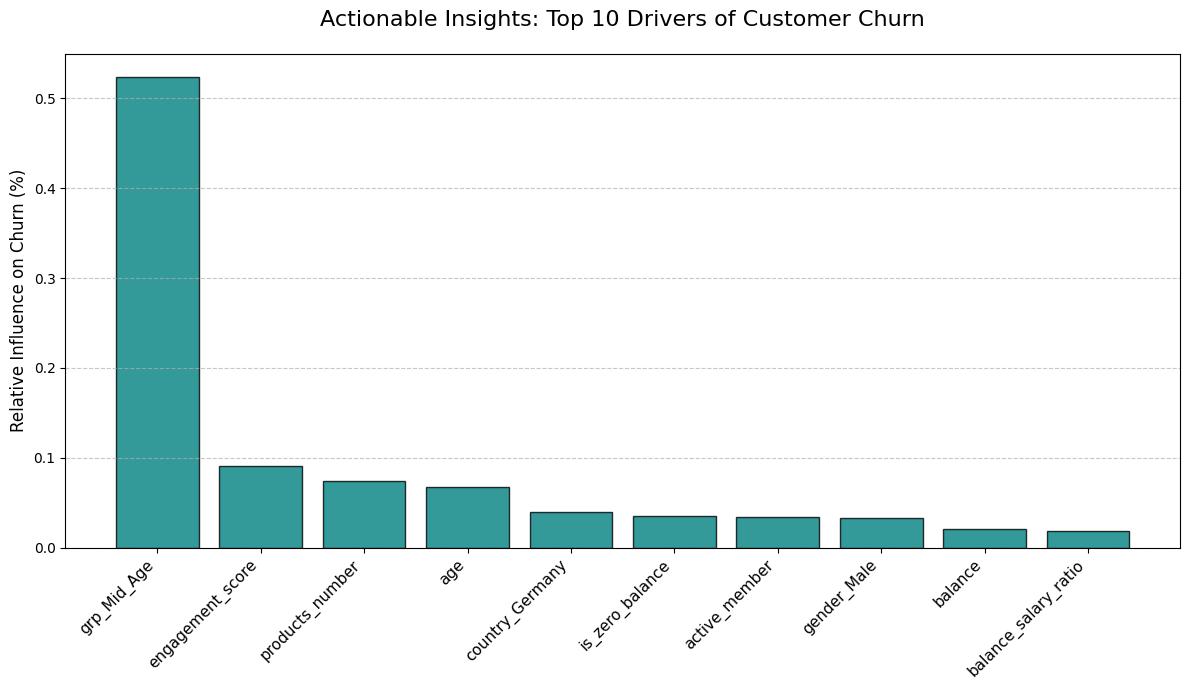

In [19]:
"""
Feature Attribution and Business Insight Generation
--------------------------------------------------
This cell focuses on model interpretability. In a production environment, 
it is not enough to have a 'black-box' model; we must identify the 
underlying factors that influence a customer's decision to leave the bank.

Key Actions:
1. Extract feature importance weights from the optimized XGBoost estimator.
2. Sort and filter for the top 10 most influential predictors.
3. Generate a high-fidelity visualization to communicate findings to stakeholders.
"""

import matplotlib.pyplot as plt
import numpy as np

def plot_business_drivers(model, feature_names):
    """
    Visualizes the top features driving the model's churn predictions.
    
    This function uses the 'Gain' metric by default for XGBoost, which 
    represents the relative contribution of each feature to the model 
    by calculating each feature's contribution to each tree in the model.
    
    Args:
        model: The trained/optimized XGBClassifier.
        feature_names (pd.Index): The list of feature names from the matrix X.
    """
    
    # 1. Feature Importance Extraction
    # We extract the raw importance scores and identify the indices of the 
    # top 10 features to keep the visualization focused and actionable.
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1] # Sort descending
    
    # 2. Visualization Configuration
    # We use a teal color palette to maintain a professional, clean aesthetic 
    # suitable for an executive presentation or technical report.
    plt.figure(figsize=(12, 7))
    plt.title("Actionable Insights: Top 10 Drivers of Customer Churn", fontsize=16, pad=20)
    
    # Plotting the top 10 features
    plt.bar(
        range(len(importances[:10])), 
        importances[indices[:10]], 
        color='#008080', # Professional Teal hex
        edgecolor='black', 
        alpha=0.8,
        align="center"
    )
    
    # 3. Axis and Label Refinement
    # Rotating labels 45 degrees ensures readability even with long feature names.
    plt.xticks(
        range(len(importances[:10])), 
        [feature_names[i] for i in indices[:10]], 
        rotation=45, 
        ha='right', 
        fontsize=11
    )
    
    plt.ylabel('Relative Influence on Churn (%)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Tight layout ensures labels are not truncated during export
    plt.tight_layout()
    plt.show()

# --- Execution ---
# We pass the 'best_xgb_model' (optimized in Cell 3) and the 
# column names from the original feature matrix X.
# Note: Feature importance represents the global influence of a feature 
# across the entire customer base.
plot_business_drivers(best_xgb_model, X.columns)

In [20]:



"""
Artifact Serialization and Persistence
--------------------------------------
This final cell handles the 'Inference Readiness' of the project. To deploy 
this model in a production environment (e.g., via a Streamlit dashboard 
or a FastAPI endpoint), we must preserve not only the XGBoost model but 
also the StandardScaler.

Key Actions:
1. Verify/Create the destination directory for model binaries.
2. Serialize the optimized XGBoost model.
3. Serialize the fitted StandardScaler to ensure consistent preprocessing 
   during real-time inference (preventing Training-Serving Skew).
"""

import joblib
import os

# 1. Directory Management
# We ensure the 'models' directory exists. In a professional MLOps workflow, 
# this prevents the script from failing due to missing infrastructure.
MODEL_DIR = '../models/'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created directory: {MODEL_DIR}")

# 2. Model Serialization
# We save the 'best_xgb_model' which contains the optimized hyperparameters 
# found during the Grid Search phase.
model_filename = os.path.join(MODEL_DIR, 'churn_model_gb.pkl')
joblib.dump(best_xgb_model, model_filename)

# 3. Scaler Serialization
# CRITICAL: During inference, new data must be scaled using the exact Mean 
# and Standard Deviation from the training set. Saving the scaler is 
# mandatory to prevent mathematical inconsistencies in production.
scaler_filename = os.path.join(MODEL_DIR, 'standard_scaler.pkl')
joblib.dump(scaler, scaler_filename)

# 4. Final Success Logging
# Providing absolute paths and file sizes is a best practice for audit logs.
print("--- MODEL PERSISTENCE SUCCESS ---")
print(f"Model Artifact: {model_filename} saved.")
print(f"Scaler Artifact: {scaler_filename} saved.")
print("Status: Pipeline is now deployment-ready.")

--- MODEL PERSISTENCE SUCCESS ---
Model Artifact: ../models/churn_model_gb.pkl saved.
Scaler Artifact: ../models/standard_scaler.pkl saved.
Status: Pipeline is now deployment-ready.
